#### Analysis of multiple stocks - for simulation over the course of n years at variable buy in frequency

Goal: This script simulates any number (typically 2) years of n-weekly prediction/closing_cost determinations and simulates for a series of chosen stocks if it is better to invest a consistent price or buy in higher/lower depending on the current performance of the stock.

Take any number of stocks and run a trendline through a series of overlapping cycles of variable length, creating a linear prediction to be applied. Assess the theoretical performance of adjusting contributions as compared to contributing a consistent amount over time.


In [56]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import date
import math
from sys import exit
import time

# import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS

ymd = str(date.today().year) + str(date.today().month).zfill(2) + str(date.today().day).zfill(2)
ymd


'20220201'

In [57]:
##### Current: Revisions 6: Dynamic Baseline


### doing
# dynamic baseline based on 260 day(?) regression
    # determine the slope
    # high rise = buy more? less? test it
# what other yfinance data available?
# Start testing buy/sell every period based on a set budget
    # will likely be a big job. maybe a lot of changes needed
    # will possibly need to make it it's own script
    # I do still want to compare to a standard buy and hold consistently approach as the baseline
# create a bare bones version that just quickly says today's invest prices
# Add functions
    # Define a function for each strategy. Opt1, opt2 etc. Should be able to get them down to a few variables
# create a strategy to find the ideal stocks to put bigger baseline investments into
# fix the v variable aspect of the invest options. Will matter if I want to cap the max invest


### To do
# fix the copy errors - do it right
# be able to do any unit of time, not just days - make it 'units' of time
    # so I can check on hypothetical minute to minute trading
    # might take a total branch off this script


### Fixed/Done
# are all ranges 1-260 or are some 0-259? - one of them was corrected, the one that sets the pred independent variable (aka index)
# test the dynamic roll_days - is it implemented everywhere it should be and everything works as expected? - seems good now
# Fix the graphs to be dynamic for dates - esp the 3 graphs stuck together - can I make the number of stuck visuals dynamic? - dropped for now
# Fix the final statement to say profit/loss or above/below dynamically
    # seems to have an issue with the reversal of percents when the total profits are negative
    # need to test with net loss stocks
# Test for different 3 year periods of time
# Fact check the dynamic dates - is everything really working?
# I really need to fix the invest days to be always on Monday or something instead of every 10 trading days
    # I can't actually trust this method until I do this
    # probably means actually using time series instead of the index replacement -- nope
# be able to run on SP500
    # SP500 core profit is unbeleiveable - any error in the code? -- a few 'weeks' variables were kept stagnant as 49
# error checking on too much history run
    # have a whole section dedicated to it and say which stock and by how much it misses
# Make a path to DL data and call to it again w/o issues
    # For flights w/o internet
# be able to do one stock at a time -- OR be able to bypass
# 3 options: every week, 2 weeks, 4 weeks, is ok if I can't do fully dynamic
# test nth week variable for odd n's that create non-integers, like investing on 3rd weeks
    # invest_weeks must be an integer
    # re-check all new facets of weeks and invest_weeks
# convert 'y' years of data to be 'w?' weeks.
    # calculate exactly how much data are needed based on weeks to look back + length of the regression. with a week or two buffer
# make the invest period dynamic
# make some logic to warn when I'm asking for too much data and one of the stocks hasn't been around long enough
# Fact check by trying different stocks entirely - do a series of poorly performing stocks, high performing stocks, and a mix
# swap to open instead of open, it's more true to my practice
# I'm picking heavy hitter stocks and then pretending I've been investing for 2 years
    # I need to pick a series of random stocks and see if I still beat baseline
# Add individual buy in prices. 
    # Do a 2 variable loop along with my j stock variable? Do a pre logic to pick custom buy ins or make all the same if only one chosen
# get opt5 ready or some other method
# something wrong with the last table output - opt 5, when pred/open2 > 1.2
    # the df data are ok, but this needs to be fixed ASAP
# add in flight 1 and flight 2 of biweekly options
# find BTC data - must do
    # either through another package or manual DL and upload
    # does the fact that BTC is daily mess up the code?
# optimize the code that creates the pred calculation. Only the last row in each dictionary entry is used
# replace most recent day entry with a to the minute entry
    # suspect at 0630, the last day's value is assigned for a bit
    # problem since I don't want to use Friday's open price on Monday morn
# fix running the btc option




In [58]:
start = time.perf_counter()

In [59]:
##### User choices go here #####

# stocks or crypto
trade_type = 'stock'
# trade_type = 'crypto'
# trade_type = 'index'


# choose stocks of interest
# stocks chosen must all have data for full range of dates
stock_list = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'] # core list
# stock_list = ['BTC-USD', 'ETH-USD']
# stock_list = ['^GSPC'] # AKA S&P 500
# stock_list = ['VFIAX', 'VTIAX', 'VTSAX']
# stock_list = ['AAPL', 'SQ', 'TSLA'] # quicker for test runs
# stock_list = ['TDOC', 'PINS'] # for net loss test runs
# stock_list = ['OSBC', 'MZZ', 'AEPPL', 'LDOS', 'AXU', 'ACM', 'MIND', 'PESI', 'JBT', 'FMN', ] # randomly pulled stocks


# choose how much to contribute each weekly period
# may choose a single value for all stocks or a set of tailored values per stock
contrib_amt = [5.00, 3.75, 2.50, 1.25, 2.50, 3.75, 2.50, 3.75, 2.50, 2.50, 2.50, 5.00, 3.75] # for core list new
# contrib_amt = [10]
# contrib_amt = [25]
# contrib_amt = [350, 50, 100] # for 3 index list



# weeks to cover (not necessarily the number of weeks where investing occurs)
# 52 = 1 year, 104 = 2 years, etc
total_weeks = 104

# invest every nth week
# 1 = every week, 2 = every 2 weeks, etc
nth_week = 1

# number of days to roll into each linear regression.
# 260 = ~1 year, 65 = ~1 quarter, 21 = ~1 month (remember, a trading week is a bit less than 5 days on average)
roll_days = 260

# opt 5 + 6: threshold of consistent buying vs increased buying
buyvalue = 1.2

# opt 7: threshold of consistent buying vs increased buying
buyvalue2 = 1

# opt 5: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * pred/open2 * multiplier)
multiplier = 3

# opt 6: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * multiplier)
multiplier2 = 4

# opt 7: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * pred/open2 * multiplier)
multiplier3 = 1.5


##### choices on the fence, maybe they should be actively chosen #####

# max amount to contribute per stock over the course of 2 years
# should be at least 50 times the bi-weekly contrib
# unlimited max is another viable strategy
invest = float('inf')
# invest = contrib_amt*invest_weeks


##### 'choices' that should really be left alone #####

# number of years to visualize
if trade_type == 'crypto':
    day_hist = (total_weeks*7)+roll_days+1 # choose for crypto ~ trading every day
else:
    day_hist = (total_weeks*5)+roll_days+1 # choose for stocks ~ trading about 5 days per week

# weeks to actually invest on
invest_weeks = math.floor(total_weeks/nth_week)


print('Total invest amount over', total_weeks, 'weeks:', invest)
print('Number of invest weeks:', invest_weeks)
print('Days of data to pull:', day_hist)


Total invest amount over 104 weeks: inf
Number of invest weeks: 104
Days of data to pull: 781


In [60]:
# duplicate contrib_amt for all stocks if only 1 listed
if len(contrib_amt) == len(stock_list):
    pass
elif len(contrib_amt) == 1: 
    contrib_amt = [contrib_amt[0] for x in enumerate(stock_list)]
else:
    print('Incorrect length of contrib_amt. Make it match the length of the stock list or be 1 value')
    exit()

contrib_amt

[5.0, 3.75, 2.5, 1.25, 2.5, 3.75, 2.5, 3.75, 2.5, 2.5, 2.5, 5.0, 3.75]

In [61]:
# check every 15 seconds for complete data
# wait times should only happen for ~1-2 minutes after market open on trading days (right after 0630am PST)

if trade_type == 'crypto' or trade_type == 'index':
  pass
else:
  x = 0
  while x < 1:
    df_now = yf.download(
      tickers = stock_list
      ,period = '1d' # set for 'today' instead
      ,interval = '1m'
    )

    df_now = df_now.head(1) # open for today
    df_now = df_now.fillna(0)

    # df_now['Open', 'AAPL'] = 0 # force a 0 for testing

    x = 1
    for i in stock_list:
      x = x * int(df_now['Open'][i])

    if x == 0: # wait 15 seconds if data aren't complete
      time.sleep(15)
    else:
      if df_now.index.day == date.today().day:
        print('Datetime of data available: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
      else:
        print('Warning, today\'s data not yet available')

df_now['Open']

# Datetime of data available:  January 28, 2022 06:31:36
# Datetime of data available:  January 31, 2022 06:31:27
# Datetime of data available:  February 01, 2022 06:31:05


[*********************100%***********************]  13 of 13 completed
Datetime of data available:  February 01, 2022 17:25:29


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
Datetime,,,,,,,,,,,,,
2022-02-01 09:30:00-05:00,174.009995,116.75,3000.0,232.369995,2756.699951,48.775002,310.410004,251.039993,364.429993,98.417503,128.5,935.210022,122.900002


In [93]:
# check the traditional open price
df_open_check = yf.download(
    tickers = stock_list
    # ,start = '2022-01-15'
    # ,end = '2022-01-18'
    ,period = str(day_hist) + 'd'
)
df_open_check['Open'].tail(2)

[*********************100%***********************]  13 of 13 completed


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
Date,,,,,,,,,,,,,
2022-01-31,170.160004,107.93,2895.0,222.949997,2683.959961,47.680000,308.950012,231.820007,353.200012,97.029999,112.860001,872.710022,119.519997
2022-02-01,174.009995,116.75,3000.0,232.369995,2756.699951,48.775002,310.410004,251.039993,364.429993,98.417503,128.500000,935.210022,122.900002


In [94]:
### Overly complex way to pull data, but I have found that 'Open' prices are just a copy of the previous day for the first few minutes of the trading day
### This method pulls in the true Open prices for today much quicker (a couple minutes after 6:30am PST)

if trade_type == 'crypto' or trade_type == 'index':
    df = yf.download(
        tickers = stock_list
        # ,start = '2022-01-15'
        # ,end = '2022-01-18'
        ,period = str(day_hist) + 'd'
    )
else:
    # Pull all data except for today
    df_bulk = yf.download(
            tickers = stock_list
            # ,start = '2022-01-15'
            # ,end = '2022-01-18'
            ,period = str(day_hist) + 'd'
        )
    df_good_index = df_bulk.copy() # used to grab the ideal index
    df_bulk.drop(df_bulk.tail(1).index,inplace=True) # bulk w/o the most recent day

    # join the data (index is still bad)
    df = pd.concat([df_bulk, df_now])

    # sub in a good index
    df = df.reindex_like(df_good_index)

    # sub in good open data for today
    for i in stock_list:
        df['Open', i][len(df)-1] = df_now['Open', i].copy()
        
df['Open']

[*********************100%***********************]  13 of 13 completed


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
Date,,,,,,,,,,,,,
2018-12-27,38.959999,17.430000,1454.199951,128.800003,1017.150024,45.619999,99.300003,32.747501,150.369995,62.619999,54.439999,63.967999,36.200001
2018-12-28,39.375000,17.530001,1473.349976,136.000000,1049.619995,46.509998,102.089996,33.000000,154.149994,63.310001,56.700001,64.620003,37.130001
2018-12-31,39.632500,18.150000,1510.800049,136.000000,1050.959961,47.090000,101.290001,33.849998,154.470001,63.770000,56.439999,67.557999,37.430000
2019-01-02,38.722500,18.010000,1465.199951,133.399994,1016.570007,45.959999,99.550003,32.660000,150.990005,63.680000,54.099998,61.220001,36.200001
2019-01-03,35.994999,18.420000,1520.010010,133.479996,1041.000000,46.150002,100.099998,33.447498,152.600006,63.459999,55.580002,61.400002,35.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26,163.500000,114.550003,2895.000000,219.610001,2611.850098,51.130001,307.989990,232.399994,352.910004,97.699997,119.010002,952.429993,125.379997
2022-01-27,162.449997,111.959999,2816.000000,214.080002,2627.219971,49.980000,302.660004,235.679993,349.399994,96.620003,107.839996,933.359985,124.000000
2022-01-28,165.710007,101.550003,2817.209961,214.300003,2600.000000,47.709999,300.230011,220.119995,343.029999,95.059998,104.949997,831.559998,118.709999


In [95]:
# allows a single stock to pass through, not just 2+ stocks. and passes through just closing
if len(stock_list) == 1:
    df[stock_list[0]] = df['Open']
    df = df[[stock_list[0]]]
else:
    df = df['Open']

# add an index and useable date
df['Index'] = np.arange(1,len(df)+1)
df['date'] = df.index

# error checking, if a stock doesn't have enough history based on the current needs
nlist = []
for i in stock_list:
    if pd.isna(df[i].iloc[0]) == True:
        nlist.append(i)
    else:
        pass

if len(nlist) >0:
    print('Stocks with not enough history', nlist)
    for j in nlist:
        print(j, 'missing days:', df['Index'].count()-df[j].count())
    exit() # Maybe not the best to add this. I still want to see the data
else:
    print('No stock history issues seen')

# in case the first row generates as nulls
# df = df.dropna() # not sure if necessary anymore

# establishing day of week, week number, trading day (each Monday)
df['dow'] = df['date'].dt.dayofweek
week_no_list = []
trade_day_list = []
week_no_var = 1
trade_day_var = 0

for i in range(len(df)):
    if i == 0:
        1
    elif df['dow'].iloc[i] > df['dow'].iloc[i-1]:
        week_no_var
        trade_day_var = 0
    else:
        week_no_var += 1
        trade_day_var = 1
    week_no_list.append(week_no_var)
    trade_day_list.append(trade_day_var)

df['week_no'] = week_no_list
df['trade_day'] = trade_day_list

# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    df.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/stocks_raw_export_{ymdt}.csv')
    # df.to_csv(f'/Volumes/Google Drive/My Drive/Python/other_projects/stocks_raw_export_{ymdt}.csv')
except:
    print('Can\'t export data')

df


No stock history issues seen


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM,Index,date,dow,week_no,trade_day
Date,,,,,,,,,,,,,,,,,,
2018-12-27,38.959999,17.430000,1454.199951,128.800003,1017.150024,45.619999,99.300003,32.747501,150.369995,62.619999,54.439999,63.967999,36.200001,1,2018-12-27,3,1,0
2018-12-28,39.375000,17.530001,1473.349976,136.000000,1049.619995,46.509998,102.089996,33.000000,154.149994,63.310001,56.700001,64.620003,37.130001,2,2018-12-28,4,1,0
2018-12-31,39.632500,18.150000,1510.800049,136.000000,1050.959961,47.090000,101.290001,33.849998,154.470001,63.770000,56.439999,67.557999,37.430000,3,2018-12-31,0,2,1
2019-01-02,38.722500,18.010000,1465.199951,133.399994,1016.570007,45.959999,99.550003,32.660000,150.990005,63.680000,54.099998,61.220001,36.200001,4,2019-01-02,2,2,0
2019-01-03,35.994999,18.420000,1520.010010,133.479996,1041.000000,46.150002,100.099998,33.447498,152.600006,63.459999,55.580002,61.400002,35.340000,5,2019-01-03,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26,163.500000,114.550003,2895.000000,219.610001,2611.850098,51.130001,307.989990,232.399994,352.910004,97.699997,119.010002,952.429993,125.379997,777,2022-01-26,2,162,0
2022-01-27,162.449997,111.959999,2816.000000,214.080002,2627.219971,49.980000,302.660004,235.679993,349.399994,96.620003,107.839996,933.359985,124.000000,778,2022-01-27,3,162,0
2022-01-28,165.710007,101.550003,2817.209961,214.300003,2600.000000,47.709999,300.230011,220.119995,343.029999,95.059998,104.949997,831.559998,118.709999,779,2022-01-28,4,162,0


In [65]:
df['AAPL'].iloc[len(df)-1]


174.00999450683594

In [106]:
df['AAPL'].iloc[len(df)-baseline_roll_days:len(df)]

Date
2021-01-22    136.279999
2021-01-25    143.070007
2021-01-26    143.600006
2021-01-27    143.429993
2021-01-28    139.520004
                 ...    
2022-01-26    163.500000
2022-01-27    162.449997
2022-01-28    165.710007
2022-01-31    170.160004
2022-02-01    174.009995
Name: AAPL, Length: 260, dtype: float64

In [128]:
####################### I/P
### 1 df, 260 days, get a slope for each stock
### given X baseline dollars, invest Y into each
# by proportion of the 1 year slope (regardless of pred/open)?

# This does end on the most recent day as opposed to the most recent Monday - issue?

baseline_roll_days = 260
baseline_total_contrib = 45

baseline_contrib = pd.DataFrame()
nlist = []
for j in stock_list:
    x = range(1,261)
    y = df[j].iloc[len(df)-baseline_roll_days:len(df)]

    m, b = np.polyfit(x, y, 1)

    nlist.append(m)


baseline_contrib['stock'] = stock_list
baseline_contrib['slope'] = nlist
baseline_contrib['min_diff'] = nlist - np.min(nlist)
baseline_contrib['ratio'] = baseline_contrib['min_diff']/np.sum(baseline_contrib['min_diff'])
baseline_contrib['contrib'] = baseline_contrib['ratio'] * baseline_total_contrib
baseline_contrib

# need all to get at least 1
# I don't want google to get 37%...
# maybe set a max?
    # also start with a square root?



# np.sum(baseline_contrib['contrib'])


,stock,slope,min_diff,ratio,contrib
0,AAPL,0.186129,0.431115,0.039336,1.770130
1,AMD,0.270543,0.515528,0.047038,2.116726
2,AMZN,0.494288,0.739274,0.067454,3.035410
3,CRM,0.201175,0.446160,0.040709,1.831906
4,GOOG,3.909099,4.154085,0.379031,17.056406
5,INTC,-0.047916,0.197069,0.017981,0.809154
6,MSFT,0.433300,0.678285,0.061889,2.784996
7,NVDA,0.714574,0.959560,0.087553,3.939891
8,QQQ,0.309375,0.554360,0.050581,2.276167
9,SBUX,0.008695,0.253681,0.023147,1.041597


In [68]:
# make a list of indices that are the Mondays where the trade should take place
# always starting with the most recent Monday

df_trade_days = df['Index'][df['trade_day'] == 1]
df_trade_days = df_trade_days.tail(total_weeks)
df_trade_days = df_trade_days.tolist()

def reverse(rev):
    rev.reverse()
    return rev
df_trade_days = reverse(df_trade_days)

nth_wk = df_trade_days[::nth_week]

print(nth_wk)
print('Number of weeks picked:',len(nth_wk))


[780, 775, 771, 766, 761, 756, 752, 747, 742, 737, 733, 728, 723, 718, 713, 708, 703, 698, 693, 688, 683, 679, 674, 669, 664, 659, 654, 649, 644, 639, 635, 630, 625, 620, 615, 611, 606, 601, 596, 591, 586, 581, 576, 571, 567, 562, 557, 552, 547, 542, 538, 533, 528, 523, 519, 514, 509, 505, 501, 496, 491, 486, 482, 477, 472, 467, 462, 457, 452, 447, 442, 437, 432, 428, 423, 418, 413, 408, 403, 398, 393, 388, 383, 379, 374, 369, 364, 359, 355, 350, 345, 340, 335, 330, 325, 321, 316, 311, 306, 301, 296, 291, 287, 282]
Number of weeks picked: 104


In [69]:
# create 1 dataframe per invest week in a dictionary, each the length of the chosen invest period
# 0 is the most recent

dataframes = {}

for j in stock_list:
    for i in range(invest_weeks):
        x = nth_wk[i]-roll_days # roll_days sets how many rows in each df
        y = nth_wk[i]

        dataframes['data' + str(i)] = df.iloc[x:y]

print(dataframes['data0'])
print(dataframes['data' + str(invest_weeks-1)])

                  AAPL         AMD         AMZN         CRM         GOOG  \
Date                                                                       
2021-01-21  133.800003   89.339996  3293.000000  223.690002  1898.000000   
2021-01-22  136.279999   94.419998  3304.310059  224.899994  1895.680054   
2021-01-25  143.070007   94.139999  3328.500000  229.690002  1920.670044   
2021-01-26  143.600006   94.910004  3296.360107  227.800003  1888.839966   
2021-01-27  143.429993   91.099998  3341.489990  223.699997  1882.530029   
...                ...         ...          ...         ...          ...   
2022-01-25  158.979996  114.099998  2844.850098  221.000000  2568.709961   
2022-01-26  163.500000  114.550003  2895.000000  219.610001  2611.850098   
2022-01-27  162.449997  111.959999  2816.000000  214.080002  2627.219971   
2022-01-28  165.710007  101.550003  2817.209961  214.300003  2600.000000   
2022-01-31  170.160004  107.930000  2895.000000  222.949997  2683.959961   

           

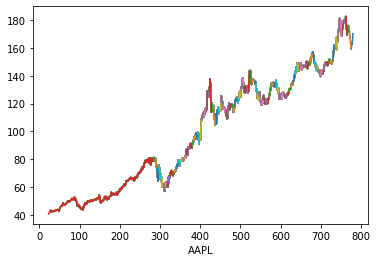

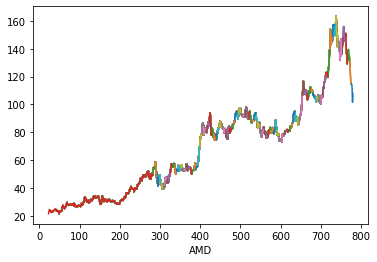

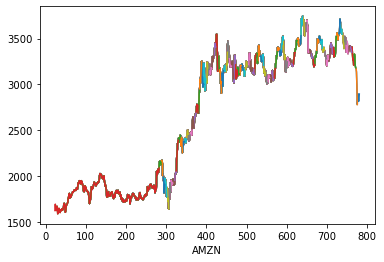

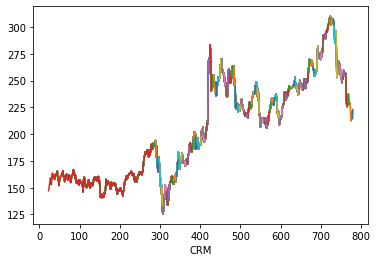

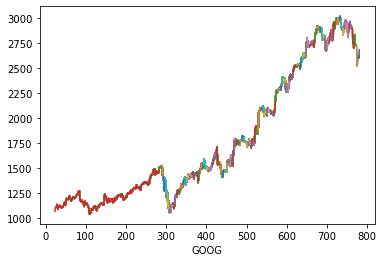

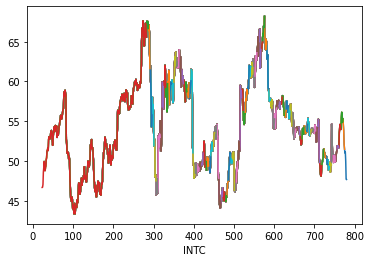

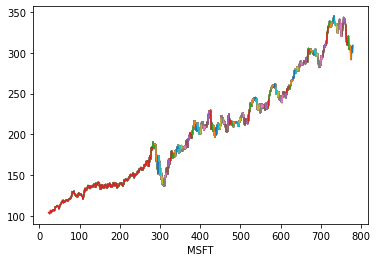

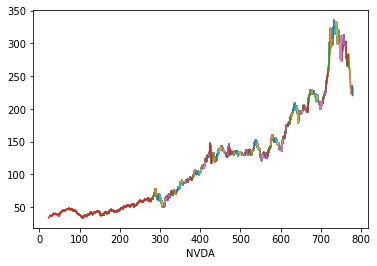

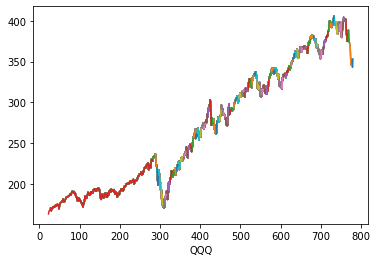

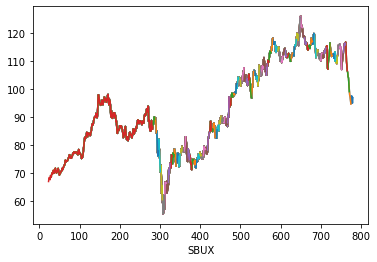

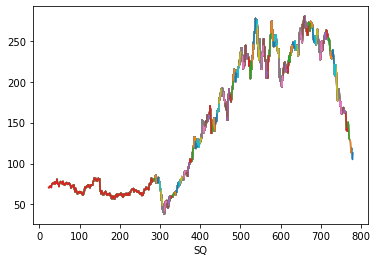

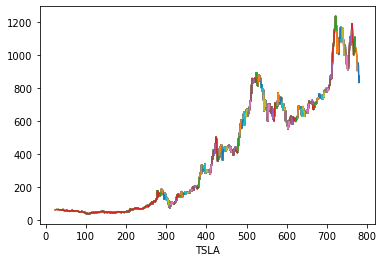

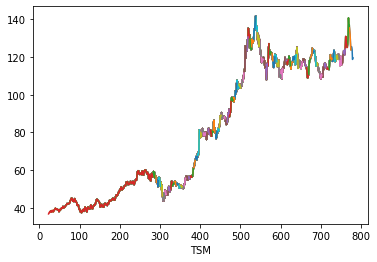

In [70]:
# shows each investing period, overlapping
### meh, less useful if I can't account for the dynamic investing periods

for i in stock_list:
    for j in range(len(dataframes)):
        x = dataframes['data' + str(j)]['Index']
        y = dataframes['data' + str(j)][str(i)]
        plt.plot(x, y)
        # m, b = np.polyfit(x, y, 1)
        # plt.plot(x, m*x + b)

    plt.xlabel(i)
    plt.show()

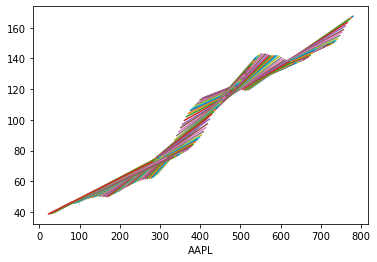

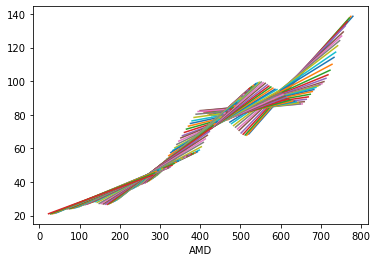

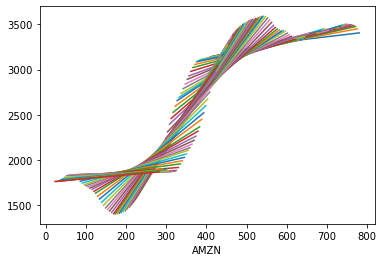

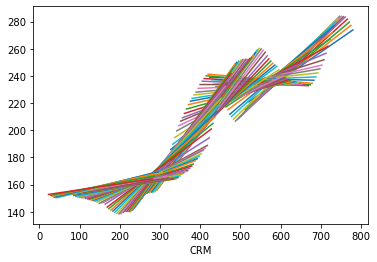

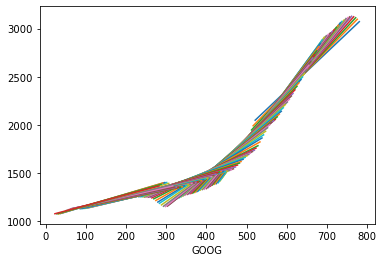

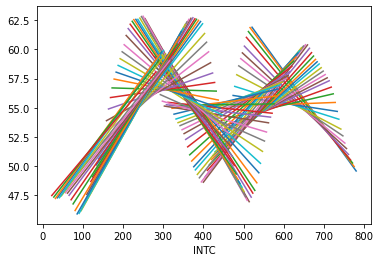

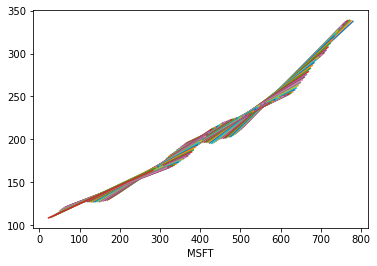

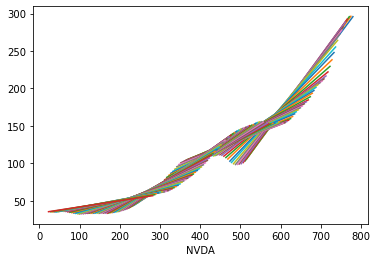

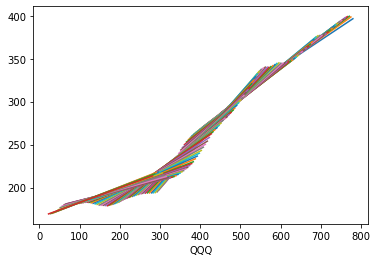

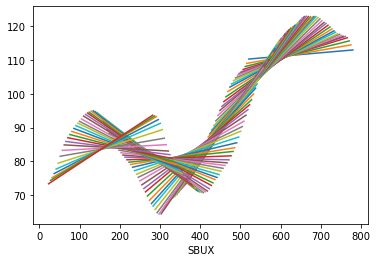

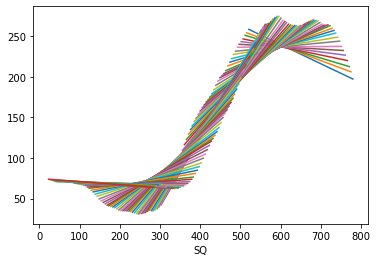

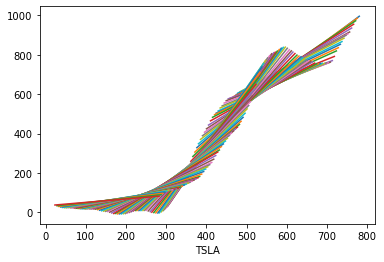

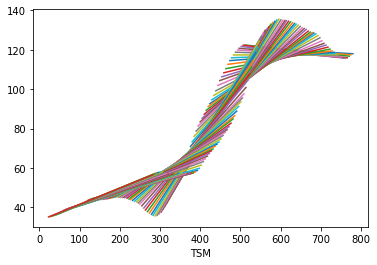

In [71]:
# plot only trendlines, every n weeks, each line representing the chosen length of data
# if the movement is too stable, these graphs won't be useable

for j in stock_list:
    for i in range(len(dataframes)):
        x = dataframes['data' + str(i)]['Index']
        y = dataframes['data' + str(i)][str(j)]

        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b)

    plt.xlabel(j)
    plt.show()

In [98]:
# create pred and pred/open list for each of the n dataframes
# sub in -1 for all calc except the last row. Only the last row of each item in the dictionary will be used

for j in stock_list:
    for e in range(len(dataframes)):
        nlist = []
        ylist = []
        y = dataframes['data' + str(e)][str(j)]

        for i in range(1,len(dataframes['data0'])+1): # create pred
            if i == len(dataframes['data0']):
                x = range(1,roll_days+1) # range must be 1-roll_days, not the auto implied 0-(roll_days-1)
                m, b = np.polyfit(x, y, 1)
                d = m*i+b
                nlist.append(d)
            else:
                nlist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes['data' + str(e)][str(j) + ' pred'] = nlist

        for i in range(1,len(dataframes['data0'])+1): # create pred/open
            if i == len(dataframes['data0']):
                d = (dataframes['data' + str(e)][str(j) + ' pred'].iloc[i-1])/(dataframes['data' + str(e)][str(j)].iloc[i-1])
                ylist.append(d)
            else:
                ylist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes['data' + str(e)][str(j) + ' pred/open'] = ylist

dataframes['data0'] # just the most recent segment


<ipython-input-98-a1d51d44da40>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred'] = nlist
<ipython-input-98-a1d51d44da40>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred/open'] = ylist


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,...,QQQ pred,QQQ pred/open,SBUX pred,SBUX pred/open,SQ pred,SQ pred/open,TSLA pred,TSLA pred/open,TSM pred,TSM pred/open
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-21,133.800003,89.339996,3293.000000,223.690002,1898.000000,59.040001,224.699997,134.184998,325.149994,105.459999,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
2021-01-22,136.279999,94.419998,3304.310059,224.899994,1895.680054,58.849998,227.080002,137.399994,325.290009,104.160004,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
2021-01-25,143.070007,94.139999,3328.500000,229.690002,1920.670044,56.380001,229.119995,137.817505,328.910004,103.750000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
2021-01-26,143.600006,94.910004,3296.360107,227.800003,1888.839966,55.279999,231.860001,135.804993,328.850006,103.400002,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
2021-01-27,143.429993,91.099998,3341.489990,223.699997,1882.530029,54.610001,238.000000,132.300003,326.260010,101.480003,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,158.979996,114.099998,2844.850098,221.000000,2568.709961,51.009998,291.519989,225.460007,346.670013,96.669998,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
2022-01-26,163.500000,114.550003,2895.000000,219.610001,2611.850098,51.130001,307.989990,232.399994,352.910004,97.699997,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
2022-01-27,162.449997,111.959999,2816.000000,214.080002,2627.219971,49.980000,302.660004,235.679993,349.399994,96.620003,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000


In [105]:
dataframes['data0']['AAPL']

Date
2021-01-21    133.800003
2021-01-22    136.279999
2021-01-25    143.070007
2021-01-26    143.600006
2021-01-27    143.429993
                 ...    
2022-01-25    158.979996
2022-01-26    163.500000
2022-01-27    162.449997
2022-01-28    165.710007
2022-01-31    170.160004
Name: AAPL, Length: 260, dtype: float64

In [73]:
# pull the last 'open' and pred/open' from each dataframe in dataframes and make a new dataframe out of it
# each row is the last open price in a given period and the final pred/open derived from the linear trendline

df = pd.DataFrame()
add_index = np.arange(1,len(dataframes)+1)
df['Index'] = add_index

for j in stock_list:
    nlist = []
    ylist = []
    zlist = []

    for e in reversed(range(len(dataframes))):
        nlist.append(dataframes['data' + str(e)][str(j) + ' pred/open'].iloc[roll_days-1])
        ylist.append(dataframes['data' + str(e)][str(j)].iloc[roll_days-1])
        zlist.append(dataframes['data' + str(e)][str(j) + ' pred'].iloc[roll_days-1])

    df[str(j)] = pd.DataFrame(ylist)
    df[str(j) + ' pred'] = pd.DataFrame(zlist)
    df[str(j) + ' pred/open'] = pd.DataFrame(nlist)

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMD,AMD pred,AMD pred/open,AMZN,AMZN pred,AMZN pred/open,...,SBUX pred/open,SQ,SQ pred,SQ pred/open,TSLA,TSLA pred,TSLA pred/open,TSM,TSM pred,TSM pred/open
94,95,159.369995,151.578767,0.951112,157.500000,117.273634,0.744595,3547.639893,3490.562324,0.983911,...,1.062321,220.460007,253.669562,1.150638,1100.989990,866.759294,0.787254,118.360001,118.158520,0.998298
95,96,164.289993,152.908935,0.930726,141.139999,121.091321,0.857952,3393.000000,3495.591779,1.030236,...,1.051659,176.869995,248.704323,1.406142,1001.510010,884.010563,0.882678,118.889999,117.572762,0.988921
96,97,181.119995,154.957063,0.855549,138.250000,124.143935,0.897967,3440.000000,3502.298099,1.018110,...,1.013002,179.110001,243.799423,1.361171,1001.090027,898.723967,0.897745,118.860001,117.026076,0.984571
97,98,168.279999,157.047556,0.933251,135.970001,126.894439,0.933253,3337.000000,3500.013682,1.048850,...,1.095906,162.990005,237.333199,1.456121,910.700012,906.393040,0.995271,115.919998,116.392539,1.004076
98,99,177.089996,158.677417,0.896027,147.509995,129.312665,0.876637,3420.739990,3496.894713,1.022263,...,1.039626,168.149994,232.293510,1.381466,1073.670044,915.559298,0.852738,121.220001,115.994598,0.956893
99,100,177.830002,161.130108,0.906091,145.139999,132.907554,0.915720,3351.000000,3495.506751,1.043123,...,1.004913,162.869995,226.559608,1.391046,1147.750000,935.590772,0.815152,124.129997,115.756986,0.932546
100,101,169.080002,163.448287,0.966692,129.080002,135.444902,1.049310,3211.709961,3487.455357,1.085856,...,1.094044,139.649994,219.973120,1.575175,1000.000000,954.814591,0.954815,125.110001,115.951825,0.926799
101,102,171.509995,165.472764,0.964800,134.500000,137.582674,1.022920,3182.100098,3476.225875,1.092431,...,1.166796,130.029999,212.472584,1.634027,1026.609985,972.439550,0.947234,136.750000,116.764481,0.853854
102,103,160.020004,166.462038,1.040258,115.400002,138.603268,1.201068,2780.000000,3450.560521,1.241209,...,1.208872,113.500000,206.026209,1.815209,904.760010,985.337359,1.089059,123.769997,117.445624,0.948902
103,104,170.160004,167.515173,0.984457,107.930000,138.639024,1.284527,2895.000000,3405.659112,1.176393,...,1.164889,112.860001,197.142126,1.746785,872.710022,995.360936,1.140540,119.519997,118.004883,0.987323


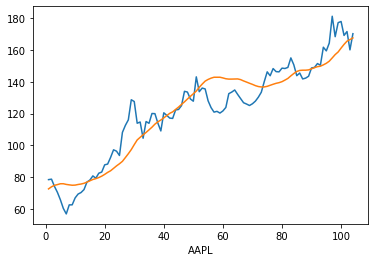

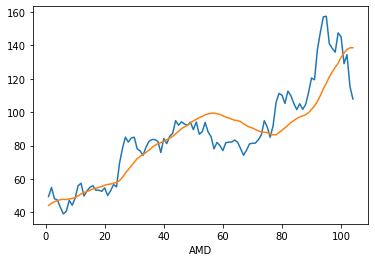

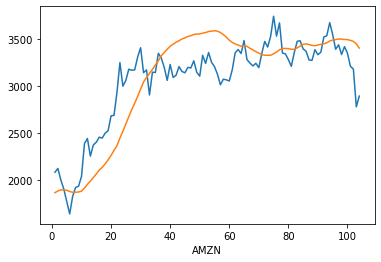

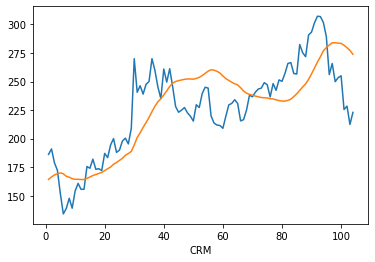

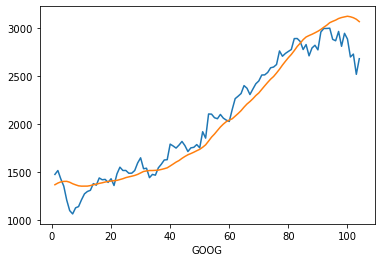

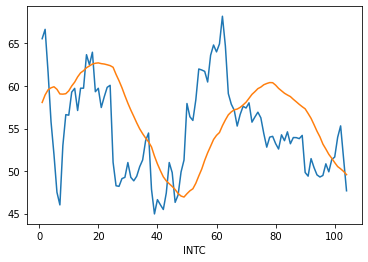

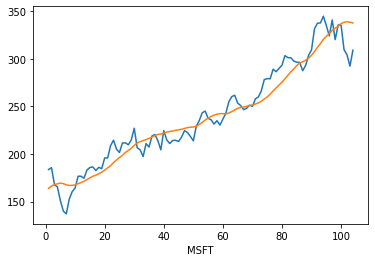

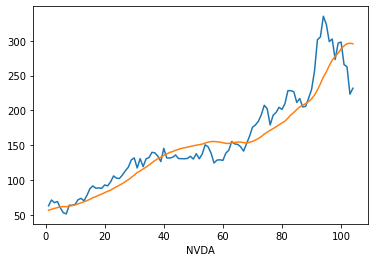

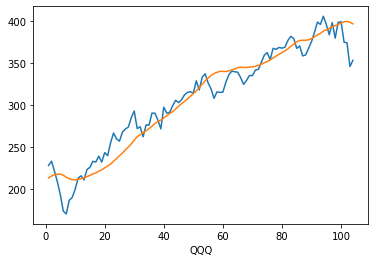

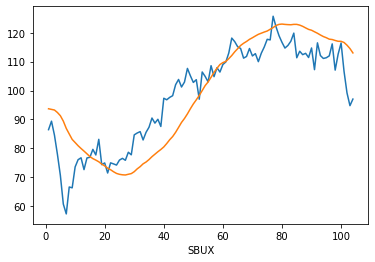

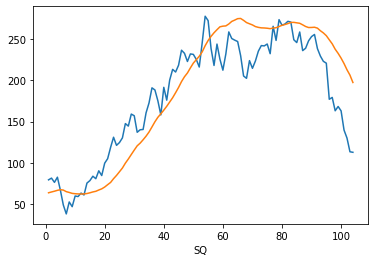

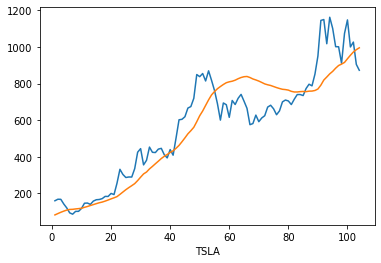

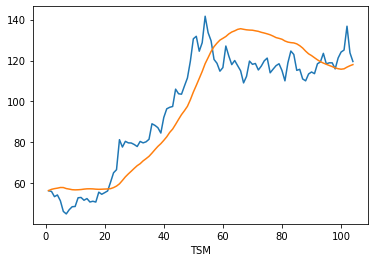

In [74]:
# plot for each stock the open price and the prediction price
# open (blue) below prediction (orange) = stock is underperforming

for i in stock_list:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    x = df['Index']
    y = df[str(i) + ' pred']
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

#### At this point, the foundation is set and strategies can be created and tested.

In [75]:
# determine the weeks where pred/open is >1 and therefore they are better weeks to buy in
# steady stocks could be at about 50/50 but stocks exponentially rising could have open to 0 pred/open > 1

for j in stock_list:
    nlist = []
    for i in range(len(df)):
        if df[str(j) + ' pred/open'].iloc[i] >= 1:
            nlist.append(1)
        else:
            nlist.append(0)

    df[str(j) + ' >1'] = nlist

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMD,AMD pred,AMD pred/open,AMZN,AMZN pred,AMZN pred/open,...,CRM >1,GOOG >1,INTC >1,MSFT >1,NVDA >1,QQQ >1,SBUX >1,SQ >1,TSLA >1,TSM >1
94,95,159.369995,151.578767,0.951112,157.500000,117.273634,0.744595,3547.639893,3490.562324,0.983911,...,0,1,1,0,0,0,1,1,0,0
95,96,164.289993,152.908935,0.930726,141.139999,121.091321,0.857952,3393.000000,3495.591779,1.030236,...,1,1,1,1,0,1,1,1,0,0
96,97,181.119995,154.957063,0.855549,138.250000,124.143935,0.897967,3440.000000,3502.298099,1.018110,...,1,1,1,0,0,0,1,1,0,0
97,98,168.279999,157.047556,0.933251,135.970001,126.894439,0.933253,3337.000000,3500.013682,1.048850,...,1,1,1,1,1,1,1,1,0,1
98,99,177.089996,158.677417,0.896027,147.509995,129.312665,0.876637,3420.739990,3496.894713,1.022263,...,1,1,1,0,0,0,1,1,0,0
99,100,177.830002,161.130108,0.906091,145.139999,132.907554,0.915720,3351.000000,3495.506751,1.043123,...,1,1,0,1,0,0,1,1,0,0
100,101,169.080002,163.448287,0.966692,129.080002,135.444902,1.049310,3211.709961,3487.455357,1.085856,...,1,1,0,1,1,1,1,1,0,0
101,102,171.509995,165.472764,0.964800,134.500000,137.582674,1.022920,3182.100098,3476.225875,1.092431,...,1,1,0,1,1,1,1,1,0,0
102,103,160.020004,166.462038,1.040258,115.400002,138.603268,1.201068,2780.000000,3450.560521,1.241209,...,1,1,0,1,1,1,1,1,1,0
103,104,170.160004,167.515173,0.984457,107.930000,138.639024,1.284527,2895.000000,3405.659112,1.176393,...,1,1,1,1,1,1,1,1,1,0


In [76]:
# square the pred/open number as a more extreme option for calculations

for j in stock_list:
    df[str(j) +' pred/open2'] = df[str(j) +' pred/open']**2 # make the value differences a little more pronounced

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMD,AMD pred,AMD pred/open,AMZN,AMZN pred,AMZN pred/open,...,CRM pred/open2,GOOG pred/open2,INTC pred/open2,MSFT pred/open2,NVDA pred/open2,QQQ pred/open2,SBUX pred/open2,SQ pred/open2,TSLA pred/open2,TSM pred/open2
94,95,159.369995,151.578767,0.951112,157.500000,117.273634,0.744595,3547.639893,3490.562324,0.983911,...,0.933840,1.134973,1.200504,0.932228,0.622370,0.968189,1.128525,1.323967,0.619770,0.996598
95,96,164.289993,152.908935,0.930726,141.139999,121.091321,0.857952,3393.000000,3495.591779,1.030236,...,1.212577,1.155973,1.154776,1.015945,0.781932,1.039557,1.105986,1.977235,0.779120,0.977964
96,97,181.119995,154.957063,0.855549,138.250000,124.143935,0.897967,3440.000000,3502.298099,1.018110,...,1.141083,1.093124,1.069565,0.936761,0.809401,0.975768,1.026174,1.852788,0.805947,0.969379
97,98,168.279999,157.047556,0.933251,135.970001,126.894439,0.933253,3337.000000,3500.013682,1.048850,...,1.291242,1.225073,1.084187,1.076825,1.034473,1.080177,1.201010,2.120289,0.990564,1.008169
98,99,177.089996,158.677417,0.896027,147.509995,129.312665,0.876637,3420.739990,3496.894713,1.022263,...,1.252592,1.119931,1.005832,0.990874,0.905259,0.986915,1.080822,1.908448,0.727162,0.915645
99,100,177.830002,161.130108,0.906091,145.139999,132.907554,0.915720,3351.000000,3495.506751,1.043123,...,1.235490,1.171700,0.974736,1.009239,0.935362,0.994023,1.009850,1.935008,0.664473,0.869643
100,101,169.080002,163.448287,0.966692,129.080002,135.444902,1.049310,3211.709961,3487.455357,1.085856,...,1.561603,1.335122,0.876415,1.194762,1.212033,1.132782,1.196932,2.481175,0.911671,0.858956
101,102,171.509995,165.472764,0.964800,134.500000,137.582674,1.022920,3182.100098,3476.225875,1.092431,...,1.498209,1.297791,0.825793,1.241381,1.268734,1.140032,1.361413,2.670046,0.897252,0.729066
102,103,160.020004,166.462038,1.040258,115.400002,138.603268,1.201068,2780.000000,3450.560521,1.241209,...,1.704042,1.509186,0.941733,1.340834,1.761493,1.327403,1.461373,3.294983,1.186050,0.900415
103,104,170.160004,167.515173,0.984457,107.930000,138.639024,1.284527,2895.000000,3405.659112,1.176393,...,1.509201,1.309571,1.081183,1.193665,1.628059,1.260102,1.356967,3.051257,1.300832,0.974807


In [77]:
# Create all of the strategies to test 

for j, z in zip(stock_list, contrib_amt):
    
# baseline - buy in $10 bi-weekly no matter what - baseline
    df[str(j) +' baseline'] = 0
    df[str(j) +' baseline_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' baseline'].iloc[i] = z
        df[str(j) +' baseline_stk'].iloc[i] = df[str(j) +' baseline'].iloc[i]/df[str(j)].iloc[i]
        v -= z
        if v < z:
            break

# opt1 - buy in every other week but proportionally to the pred/open
    df[str(j) +' opt1'] = 0
    df[str(j) +' opt1_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt1'].iloc[i] = z*df[str(j) +' pred/open'].iloc[i]
        df[str(j) +' opt1_stk'].iloc[i] = df[str(j) +' opt1'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open'].iloc[t]:
            break

# opt2 - buy in every other week but proportionally to the square of pred/open
    df[str(j) +' opt2'] = 0
    df[str(j) +' opt2_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt2'].iloc[i] = z*df[str(j) +' pred/open2'].iloc[i]
        df[str(j) +' opt2_stk'].iloc[i] = df[str(j) +' opt2'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# opt3 - buy in every other week. 0 on days <1 and twice the normal bi-weekly contribution on days >= 1
    df[str(j) +' opt3'] = 0
    df[str(j) +' opt3_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt3'].iloc[i] = z*2*df[str(j) +' >1'].iloc[i] 
        df[str(j) +' opt3_stk'].iloc[i] = df[str(j) +' opt3'].iloc[i]/df[str(j)].iloc[i]
        v -= z*2*df[str(j) +' >1'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*2*df[str(j) +' >1'].iloc[t]:
            break

# opt4 - buy in every other week but proportionally to the inverse of pred/open
# This is more of a validation and will ideally return negative compared to baseline
    df[str(j) +' opt4'] = 0
    df[str(j) +' opt4_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt4'].iloc[i] = z/df[str(j) +' pred/open'].iloc[i]
        df[str(j) +' opt4_stk'].iloc[i] = df[str(j) +' opt4'].iloc[i]/df[str(j)].iloc[i]
        v -= z/df[str(j) +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z/df[str(j) +' pred/open'].iloc[t]:
            break

# opt5
    df[str(j) +' opt5'] = 0
    df[str(j) +' opt5_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue:
            df[str(j) +' opt5'].iloc[i] = z
        else:
            #df[str(j) +' opt5'].iloc[i] = round(z * df[str(j) +' pred/open2'].iloc[i] * multiplier,0)
            df[str(j) +' opt5'].iloc[i] = round(z * df[str(j) +' pred/open2'].iloc[i] * multiplier,2)
        df[str(j) +' opt5_stk'].iloc[i] = df[str(j) +' opt5'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# opt6
    df[str(j) +' opt6'] = 0
    df[str(j) +' opt6_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue:
            df[str(j) +' opt6'].iloc[i] = z
        else:
            df[str(j) +' opt6'].iloc[i] = z * multiplier2
        df[str(j) +' opt6_stk'].iloc[i] = df[str(j) +' opt6'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# opt7
    df[str(j) +' opt7'] = 0
    df[str(j) +' opt7_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue2:
            df[str(j) +' opt7'].iloc[i] = z
        else:
            # df[str(j) +' opt7'].iloc[i] = round(z * df[str(j) +' pred/open2'].iloc[i] * multiplier3,0)
            df[str(j) +' opt7'].iloc[i] = round(z * df[str(j) +' pred/open2'].iloc[i] * multiplier3,2)
        df[str(j) +' opt7_stk'].iloc[i] = df[str(j) +' opt7'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break



######################## I/P
# for j, z in zip(stock_list, contrib_amt):
# opt8
    df[str(j) +' opt8'] = 0
    df[str(j) +' opt8_sell'] = 0 ############# must track how much I sell. I can just sum the purchases and sales
    df[str(j) +' opt8_stk'] = 0

    v = invest
    stock_non_neg = 0 ########### make sure stock in never negativew

    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue and df[str(j) +' pred/open2'].iloc[i] > 1/buyvalue: # buy normal
            df[str(j) +' opt8'].iloc[i] = z
        elif df[str(j) +' pred/open2'].iloc[i] > buyvalue: # buy higher
            df[str(j) +' opt8'].iloc[i] = round(z * df[str(j) +' pred/open2'].iloc[i] * multiplier, 2)
        else: # sell option
            df[str(j) +' opt8'].iloc[i] = round(z / 1/df[str(j) +' pred/open2'].iloc[i] * multiplier * -1, 2)
        
        df[str(j) +' opt8_stk'].iloc[i] = df[str(j) +' opt8'].iloc[i]/df[str(j)].iloc[i] # stock gain/loss per week

        stock_non_neg += df[str(j) +' opt8_stk'].iloc[i]
            ######## how to recursively not buy in when the stock will hit negative? maybe set dummy mirror variables?

        v -= z*df[str(j) +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    df.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/stocks_df_export_{ymdt}.csv', index = False)
except:
    print('Can\'t export data')

df.tail(10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Can't export data


,Index,AAPL,AAPL pred,AAPL pred/open,AMD,AMD pred,AMD pred/open,AMZN,AMZN pred,AMZN pred/open,...,TSM opt4_stk,TSM opt5,TSM opt5_stk,TSM opt6,TSM opt6_stk,TSM opt7,TSM opt7_stk,TSM opt8,TSM opt8_sell,TSM opt8_stk
94,95,159.369995,151.578767,0.951112,157.500000,117.273634,0.744595,3547.639893,3490.562324,0.983911,...,0.031737,3.75,0.031683,3.75,0.031683,3.75,0.031683,3.75,0,0.031683
95,96,164.289993,152.908935,0.930726,141.139999,121.091321,0.857952,3393.000000,3495.591779,1.030236,...,0.031895,3.75,0.031542,3.75,0.031542,3.75,0.031542,3.75,0,0.031542
96,97,181.119995,154.957063,0.855549,138.250000,124.143935,0.897967,3440.000000,3502.298099,1.018110,...,0.032044,3.75,0.031550,3.75,0.031550,3.75,0.031550,3.75,0,0.031550
97,98,168.279999,157.047556,0.933251,135.970001,126.894439,0.933253,3337.000000,3500.013682,1.048850,...,0.032219,3.75,0.032350,3.75,0.032350,5.67,0.048913,3.75,0,0.032350
98,99,177.089996,158.677417,0.896027,147.509995,129.312665,0.876637,3420.739990,3496.894713,1.022263,...,0.032329,3.75,0.030935,3.75,0.030935,3.75,0.030935,3.75,0,0.030935
99,100,177.830002,161.130108,0.906091,145.139999,132.907554,0.915720,3351.000000,3495.506751,1.043123,...,0.032395,3.75,0.030210,3.75,0.030210,3.75,0.030210,3.75,0,0.030210
100,101,169.080002,163.448287,0.966692,129.080002,135.444902,1.049310,3211.709961,3487.455357,1.085856,...,0.032341,3.75,0.029974,3.75,0.029974,3.75,0.029974,3.75,0,0.029974
101,102,171.509995,165.472764,0.964800,134.500000,137.582674,1.022920,3182.100098,3476.225875,1.092431,...,0.032116,3.75,0.027422,3.75,0.027422,3.75,0.027422,-15.43,0,-0.112834
102,103,160.020004,166.462038,1.040258,115.400002,138.603268,1.201068,2780.000000,3450.560521,1.241209,...,0.031930,3.75,0.030298,3.75,0.030298,3.75,0.030298,3.75,0,0.030298
103,104,170.160004,167.515173,0.984457,107.930000,138.639024,1.284527,2895.000000,3405.659112,1.176393,...,0.031778,3.75,0.031376,3.75,0.031376,3.75,0.031376,3.75,0,0.031376


In [78]:
#df
#df.to_csv(f'/Volumes/Google Drive/My Drive/Python/other_projects/data_export.csv', index = False)

In [79]:
print('baseline - contribute consistently every other week')
print('opt1 - buy in every other week proportional to the pred/open variable')
print('opt2 - buy in every other week proportional to the square of pred/open variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/open variable')
print('opt5 - normal buy in, boosted at high pred/open')
print('opt6 - normal buy in, boosted at high pred/open, more consistently')
print('opt7 - normal buy in, boosted at high pred/open, smaller multiplier')
print('opt8 - buy/sell')

df_bought_in = pd.DataFrame()
df_profit = pd.DataFrame()
df_diff = pd.DataFrame()

for j in stock_list:
    d = {'name': [str(j) +' baseline', str(j) +' opt1', str(j) +' opt2', str(j) +' opt3', str(j) +' opt4', str(j) +' opt5', str(j) +' opt6', str(j) +' opt7', str(j) +' opt8']
         ,'bought_in': [
             round(sum(df[str(j) +' baseline']),2),
             round(sum(df[str(j) +' opt1']),2), 
             round(sum(df[str(j) +' opt2']),2), 
             round(sum(df[str(j) +' opt3']),2),
             round(sum(df[str(j) +' opt4']),2),
             round(sum(df[str(j) +' opt5']),2),
             round(sum(df[str(j) +' opt6']),2),
             round(sum(df[str(j) +' opt7']),2),
             round(sum(df[str(j) +' opt8']),2)]
         ,'stocks_held': [
             round(sum(df[str(j) +' baseline_stk']),4), 
             round(sum(df[str(j) +' opt1_stk']),4), 
             round(sum(df[str(j) +' opt2_stk']),4), 
             round(sum(df[str(j) +' opt3_stk']),4), 
             round(sum(df[str(j) +' opt4_stk']),4), 
             round(sum(df[str(j) +' opt5_stk']),4),
             round(sum(df[str(j) +' opt6_stk']),4),
             round(sum(df[str(j) +' opt7_stk']),4),
             round(sum(df[str(j) +' opt8_stk']),4)]
#          ,'cost_per_stock': [
#              sum(df[str(j) +' baseline'])/sum(df[str(j) +' baseline_stk']), 
#              sum(df[str(j) +' opt1'])/sum(df[str(j) +' opt1_stk']), 
#              sum(df[str(j) +' opt2'])/sum(df[str(j) +' opt2_stk']), 
#              sum(df[str(j) +' opt3'])/sum(df[str(j) +' opt3_stk']), 
#             sum(df[str(j) +' opt4'])/sum(df[str(j) +' opt4_stk'])]
         ,'profit': [
             round((sum(df[str(j) +' baseline_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' baseline']),2),
             round((sum(df[str(j) +' opt1_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt1']),2), 
             round((sum(df[str(j) +' opt2_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt2']),2), 
             round((sum(df[str(j) +' opt3_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt3']),2), 
             round((sum(df[str(j) +' opt4_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt4']),2), 
             round((sum(df[str(j) +' opt5_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt5']),2),
             round((sum(df[str(j) +' opt6_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt6']),2),
             round((sum(df[str(j) +' opt7_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt7']),2),
             round((sum(df[str(j) +' opt8_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt8']),2)]
        }

    df2 = pd.DataFrame(data=d)

    df2['diff'] = 0
    df2['diff'].iloc[1] = round(df2['profit'].iloc[1]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[2] = round(df2['profit'].iloc[2]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[3] = round(df2['profit'].iloc[3]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[4] = round(df2['profit'].iloc[4]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[5] = round(df2['profit'].iloc[5]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[6] = round(df2['profit'].iloc[6]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[7] = round(df2['profit'].iloc[7]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[8] = round(df2['profit'].iloc[8]-df2['profit'].iloc[0],2)

    df2['%_diff'] = round((df2['diff']/df2['profit'])*100,2)

    print('')
    print(df2)
    
    df_bought_in[str(j) + ' bought_in'] = df2['bought_in']
    df_profit[str(j) + ' profit'] = df2['profit']
    df_diff[str(j) + ' diff'] = df2['diff']

baseline - contribute consistently every other week
opt1 - buy in every other week proportional to the pred/open variable
opt2 - buy in every other week proportional to the square of pred/open variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1
opt4 - buy in every other week inversely proportional to the pred/open variable
opt5 - normal buy in, boosted at high pred/open
opt6 - normal buy in, boosted at high pred/open, more consistently
opt7 - normal buy in, boosted at high pred/open, smaller multiplier
opt8 - buy/sell

            name  bought_in  stocks_held  profit    diff  %_diff
0  AAPL baseline     520.00       4.6067  263.87    0.00    0.00
1      AAPL opt1     522.58       4.6838  274.41   10.54    3.84
2      AAPL opt2     529.98       4.8128  288.97   25.10    8.69
3      AAPL opt3     490.00       4.6340  298.52   34.65   11.61
4      AAPL opt4     522.13       4.5781  256.88   -6.99   -2.72
5      AAPL opt5     781.41       

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [80]:
# how much was ivested
# no amount should be above the previously set 'invest' amount
# row 0 = baselines. Rows 1-4 = options 1-4
df_bought_in

,AAPL bought_in,AMD bought_in,AMZN bought_in,CRM bought_in,GOOG bought_in,INTC bought_in,MSFT bought_in,NVDA bought_in,QQQ bought_in,SBUX bought_in,SQ bought_in,TSLA bought_in,TSM bought_in
0,520.00,390.00,260.00,130.00,260.00,390.00,260.00,390.00,260.00,260.00,260.00,520.00,390.00
1,522.58,387.86,260.91,131.23,259.11,402.87,258.82,377.57,259.99,263.31,267.29,495.52,394.59
2,529.98,392.64,264.40,134.34,259.97,420.84,258.62,371.42,261.05,270.32,289.92,493.84,405.36
3,490.00,360.00,300.00,115.00,185.00,547.50,220.00,285.00,205.00,300.00,265.00,390.00,442.50
4,522.13,399.33,261.79,130.59,262.51,382.05,262.13,409.07,261.01,259.94,266.07,572.12,391.66
5,781.41,687.07,403.51,245.53,348.50,706.60,298.40,619.65,320.34,383.04,611.38,1024.83,778.54
6,775.00,671.25,410.00,242.50,342.50,705.00,297.50,615.00,320.00,365.00,515.00,955.00,783.75
7,707.68,544.66,369.86,182.27,330.96,605.86,332.60,509.57,330.34,377.20,424.93,732.58,577.34
8,473.14,138.17,108.40,95.48,253.10,373.70,250.88,-240.57,237.43,108.46,52.74,-639.37,147.49


In [81]:
# profits made above/below the investment
# row 0 = baselines. Rows 1-4 = options 1-4
df_profit

,AAPL profit,AMD profit,AMZN profit,CRM profit,GOOG profit,INTC profit,MSFT profit,NVDA profit,QQQ profit,SBUX profit,SQ profit,TSLA profit,TSM profit
0,263.87,150.25,-5.65,2.68,112.72,-47.05,90.38,317.85,51.70,6.46,-53.12,739.76,144.33
1,274.41,157.47,-6.60,3.83,114.43,-46.16,91.50,310.58,52.57,8.22,-52.29,688.43,151.26
2,288.97,166.55,-7.50,5.05,117.42,-45.78,93.15,307.72,54.02,11.09,-50.36,673.88,160.98
3,298.52,199.60,-18.73,8.94,85.37,-50.52,94.28,219.85,42.12,0.42,-56.77,503.51,211.80
4,256.88,144.64,-4.63,1.58,112.12,-48.52,89.76,329.59,51.33,5.49,-53.75,841.72,140.03
5,501.33,293.57,-8.59,13.78,182.86,-62.48,119.23,517.28,90.10,40.58,-83.87,1429.63,321.73
6,480.51,287.44,-9.26,12.61,173.95,-63.49,117.24,512.89,87.93,28.89,-104.14,1345.91,314.61
7,396.04,232.76,-11.51,7.34,151.02,-64.65,123.98,413.51,70.42,15.05,-68.62,1012.27,236.52
8,376.01,222.37,-29.73,30.09,143.69,13.19,92.29,-148.28,64.98,26.36,-26.68,-1399.73,146.99


In [82]:
# profits made above/below the baseline profits
# row 0 = baselines. Rows 1-4 = options 1-4
df_diff[1:]

,AAPL diff,AMD diff,AMZN diff,CRM diff,GOOG diff,INTC diff,MSFT diff,NVDA diff,QQQ diff,SBUX diff,SQ diff,TSLA diff,TSM diff
1,10.54,7.22,-0.95,1.15,1.71,0.89,1.12,-7.27,0.87,1.76,0.83,-51.33,6.93
2,25.10,16.30,-1.85,2.37,4.70,1.27,2.77,-10.13,2.32,4.63,2.76,-65.88,16.65
3,34.65,49.35,-13.08,6.26,-27.35,-3.47,3.90,-98.00,-9.58,-6.04,-3.65,-236.25,67.47
4,-6.99,-5.61,1.02,-1.10,-0.60,-1.47,-0.62,11.74,-0.37,-0.97,-0.63,101.96,-4.30
5,237.46,143.32,-2.94,11.10,70.14,-15.43,28.85,199.43,38.40,34.12,-30.75,689.87,177.40
6,216.64,137.19,-3.61,9.93,61.23,-16.44,26.86,195.04,36.23,22.43,-51.02,606.15,170.28
7,132.17,82.51,-5.86,4.66,38.30,-17.60,33.60,95.66,18.72,8.59,-15.50,272.51,92.19
8,112.14,72.12,-24.08,27.41,30.97,60.24,1.91,-466.13,13.28,19.90,26.44,-2139.49,2.66


In [83]:
# Final summary calculations
# if you take chosen stocks and apply chosen investment strategies over the course of 2 years, 
# investing bi-weekly, you get these results:

print('Current date/time: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
print('')

print('baseline - contribute consistently every other week')
print('opt1 - buy in every other week proportional to the pred/open variable')
print('opt2 - buy in every other week proportional to the square of pred/open variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/open variable')
print('opt5 - normal buy in, boosted at high pred/open, proportional to the pred/open')
print('opt6 - normal buy in, boosted at high pred/open, more consistently')
print('opt7 - normal buy in, boosted at high pred/open, smaller multiplier')
print('opt8 - buy/sell')

print('')

# needed for when baseline total profit is negative
if sum(df_profit.iloc[0]) >= 0:
      x = 1
else:
      x = -1

if sum(df_diff.iloc[1]) >= 0:
      print(round(sum(df_diff.iloc[1]),2), 'opt1 profit over baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[1]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[2]) >= 0:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 profit over baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[3]) >= 0:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 profit over baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 loss compared to baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[4]) >= 0:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 profit over baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 loss compared to baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[5]) >= 0:
      print(round(sum(df_diff.iloc[5]),2), 'opt5 profit over baseline.', 
            round(sum(df_profit.iloc[5]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[5]),2), 'investment.',
            round((sum(df_diff.iloc[5])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[5]),2), 'opt5 loss compared to baseline.', 
            round(sum(df_profit.iloc[5]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[5]),2), 'investment.',
            round((sum(df_diff.iloc[5])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[6]) >= 0:
      print(round(sum(df_diff.iloc[6]),2), 'opt6 profit over baseline.', 
            round(sum(df_profit.iloc[6]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[6]),2), 'investment.',
            round((sum(df_diff.iloc[6])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[6]),2), 'opt6 loss compared to baseline.', 
            round(sum(df_profit.iloc[6]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[6]),2), 'investment.',
            round((sum(df_diff.iloc[6])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[7]) >= 0:
      print(round(sum(df_diff.iloc[7]),2), 'opt6 profit over baseline.', 
            round(sum(df_profit.iloc[7]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[7]),2), 'investment.',
            round((sum(df_diff.iloc[7])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[7]),2), 'opt6 loss compared to baseline.', 
            round(sum(df_profit.iloc[7]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[7]),2), 'investment.',
            round((sum(df_diff.iloc[7])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[8]) >= 0:
      print(round(sum(df_diff.iloc[8]),2), 'opt7 profit over baseline.', 
            round(sum(df_profit.iloc[8]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[8]),2), 'investment.',
            round((sum(df_diff.iloc[8])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[8]),2), 'opt8 loss compared to baseline.', 
            round(sum(df_profit.iloc[8]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[8]),2), 'investment.',
            round((sum(df_diff.iloc[8])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')


Current date/time:  February 01, 2022 17:25:52

baseline - contribute consistently every other week
opt1 - buy in every other week proportional to the pred/open variable
opt2 - buy in every other week proportional to the square of pred/open variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1
opt4 - buy in every other week inversely proportional to the pred/open variable
opt5 - normal buy in, boosted at high pred/open, proportional to the pred/open
opt6 - normal buy in, boosted at high pred/open, more consistently
opt7 - normal buy in, boosted at high pred/open, smaller multiplier
opt8 - buy/sell

-26.53 opt2 loss compared to baseline. 1747.65 core profit on 4281.65 investment. -1.5 percent below baseline profit.
1.01 opt2 profit over baseline. 1775.19 core profit on 4352.7 investment. 0.06 percent above baseline profit.
-235.79 opt3 loss compared to baseline. 1538.39 core profit on 4105.0 investment. -13.29 percent below baseline profi

In [84]:
now = pd.DataFrame()
opts = [f'# >= {buyvalue}', f'# < {buyvalue}', 'Total', f'Rate of >= {buyvalue}']
now['Method'] = opts

for j in stock_list:
    nlist = []
    for i in range(len(opts)):
        if i == 0:
            x = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] >= buyvalue:
                    x += 1
                else:
                    pass
        elif i == 1: 
            x = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] < buyvalue:
                    x += 1
                else:
                    pass
        elif i == 2:
            x = len(df)   
        elif i == 3:
            y = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] >= buyvalue:
                    y += 1
                else:
                    pass
            x = round(y/len(df),4)     
        else: -1
        nlist.append(f'{x}')
    now[str(j)] = nlist

now

,Method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,# >= 1.2,17,24,19,29,10,28,5,19,7,13,33,28,35
1,# < 1.2,86,79,84,74,93,75,98,84,96,90,70,75,68
2,Total,104,104,104,104,104,104,104,104,104,104,104,104,104
3,Rate of >= 1.2,0.1635,0.2308,0.1827,0.2788,0.0962,0.2692,0.0481,0.1827,0.0673,0.125,0.3173,0.2692,0.3365


In [85]:
print('Using one of the strategies, Most recent Monday\'s buy in values are listed.')

now = pd.DataFrame()
opts = ['baseline', 'opt1', 'opt2', 'opt3', 'opt4', 'opt5', 'opt6', 'opt7', 'pred/open2']
now['Method'] = opts

for j, z in zip(stock_list, contrib_amt):
    nlist = []
    for i in range(len(opts)):
        if i == 0:
            x = z
        elif i == 1: 
            x = z * df[str(j) + ' pred/open'].iloc[invest_weeks-1]
        elif i == 2:
            x = z * df[str(j) + ' pred/open2'].iloc[invest_weeks-1]
        elif i == 3:
            x = z * 2 * df[str(j) + ' >1'].iloc[invest_weeks-1]
        elif i == 4: 
            x = z / df[str(j) + ' pred/open'].iloc[invest_weeks-1]
        elif i == 5:
            if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
                x = z
            else:
                # x = round(z * df[str(j) +' pred/open2'].iloc[invest_weeks-1] * multiplier,0)
                x = round(z * df[str(j) +' pred/open2'].iloc[invest_weeks-1] * multiplier,2)
        elif i == 6:
            if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
                x = z
            else:
                x = z * multiplier2
        elif i == 7:
            if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue2:
                x = z
            else:
                # x = round(z * df[str(j) +' pred/open2'].iloc[invest_weeks-1] * multiplier3,0)
                x = round(z * df[str(j) +' pred/open2'].iloc[invest_weeks-1] * multiplier3,2)
        elif i == 8:
            x = df[str(j) + ' pred/open2'].iloc[invest_weeks-1]
        else: -1
        nlist.append(round(x,4))
    now[str(j)] = nlist

now


Using one of the strategies, Most recent Monday's buy in values are listed.


,Method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,baseline,5.0000,3.7500,2.5000,1.2500,2.5000,3.7500,2.5000,3.7500,2.5000,2.5000,2.5000,5.0000,3.7500
1,opt1,4.9223,4.8170,2.9410,1.5356,2.8609,3.8992,2.7314,4.7848,2.8064,2.9122,4.3670,5.7027,3.7025
2,opt2,4.8458,6.1875,3.4598,1.8865,3.2739,4.0544,2.9842,6.1052,3.1503,3.3924,7.6281,6.5042,3.6555
3,opt3,0.0000,7.5000,5.0000,2.5000,5.0000,7.5000,5.0000,7.5000,5.0000,5.0000,5.0000,10.0000,0.0000
4,opt4,5.0789,2.9194,2.1251,1.0175,2.1846,3.6065,2.2882,2.9390,2.2271,2.1461,1.4312,4.3839,3.7981
5,opt5,5.0000,18.5600,10.3800,5.6600,9.8200,3.7500,2.5000,18.3200,9.4500,10.1800,22.8800,19.5100,3.7500
6,opt6,5.0000,15.0000,10.0000,5.0000,10.0000,3.7500,2.5000,15.0000,10.0000,10.0000,10.0000,20.0000,3.7500
7,opt7,5.0000,9.2800,5.1900,2.8300,4.9100,6.0800,4.4800,9.1600,4.7300,5.0900,11.4400,9.7600,3.7500
8,pred/open2,0.9692,1.6500,1.3839,1.5092,1.3096,1.0812,1.1937,1.6281,1.2601,1.3570,3.0513,1.3008,0.9748


In [86]:
# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    now.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/stocks_export_{ymdt}.csv', index = False)
except:
    print('Can\'t export data')

Can't export data


In [87]:
print(f'Current setup for active use - opt5: {roll_days = }, pred/open2, {buyvalue = }, {multiplier = }, {invest = }')
print('Most recent Monday\'s buy in values are listed.')

opt0_cost = 0
opt5_cost = 0
for i in stock_list:
    opt0_cost += now.iloc[0][i]
    opt5_cost += now.iloc[5][i]
    
print(f'{opt0_cost} - baseline total today buy in')
print(f'{opt5_cost} - opt5 total today buy in')

now.iloc[[8, 0, 5]]


Current setup for active use - opt5: roll_days = 260, pred/open2, buyvalue = 1.2, multiplier = 3, invest = inf
Most recent Monday's buy in values are listed.
41.25 - baseline total today buy in
139.76 - opt5 total today buy in


,Method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
8,pred/open2,0.9692,1.65,1.3839,1.5092,1.3096,1.0812,1.1937,1.6281,1.2601,1.357,3.0513,1.3008,0.9748
0,baseline,5.0000,3.75,2.5000,1.2500,2.5000,3.7500,2.5000,3.7500,2.5000,2.500,2.5000,5.0000,3.7500
5,opt5,5.0000,18.56,10.3800,5.6600,9.8200,3.7500,2.5000,18.3200,9.4500,10.180,22.8800,19.5100,3.7500


In [88]:
print('pred/open2 current values')
for j in stock_list:
    if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
        print(round(df[str(j) +' pred/open2'].iloc[invest_weeks-1],4), j)
    else:
        print(round(df[str(j) +' pred/open2'].iloc[invest_weeks-1],4), j, '>', buyvalue)

pred/open2 current values
0.9692 AAPL
1.65 AMD > 1.2
1.3839 AMZN > 1.2
1.5092 CRM > 1.2
1.3096 GOOG > 1.2
1.0812 INTC
1.1937 MSFT
1.6281 NVDA > 1.2
1.2601 QQQ > 1.2
1.357 SBUX > 1.2
3.0513 SQ > 1.2
1.3008 TSLA > 1.2
0.9748 TSM


In [89]:
end = time.perf_counter()
print(f'Seconds to run the script: {round(end - start,2)}')

AttributeError: 'numpy.ndarray' object has no attribute 'perf_counter'

#### "Final" notes

Stocks going up parabolically will almost never be above 1, so I can't simply not buy in when pred/open is not above 1. GOOG is like this as of 9/3/2021. This kind of stock will also produce worse than baseline profits for opt1 and opt2 because they won't be investing the full 500 over the course of the investment period. Option 3 is not viable.

Stocks in a big S-curve, flat ~ rise ~ flat, will only have a pred/open above 1 on the latter half of the year, so again, I can't contribute nothing. TSM and TSLA are like this as of 9/3/2021. Option 3 is not viable.

Options 1 and 2 seem to do well on stocks with lots of variation but loses on stocks seeing exponential growth. Missing out on a stock growing exponentially will surely wipe out all gains seen elsewhere. There may be some merit to opt4, the inverse method, but the baseline probably remains the best method if a single method is picked, and based only on daily closing values, for across the board investing.

#### Round 2 running notes - 12/15/2021
rolling 1 quarter has already shown to be better than at least 1 year or 1 month<br>
1 quarter instead of my original hypothesis of 1 year seems to be much more promising<br>
opt2 focus<br>
excluded MDB due to shorter stock lifespan<b>

Current run, 3 year period ending 12/15/2021:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2018-12-15' - '2021-12-15'<br>
Rolling: 65 days (~1 quarter)<br>
353.39 opt2 profit over baseline. 4425.11 core profit on 6425.96 investment. 8.68 percent above baseline profit.<br>
TSLA represents most of the gains over baseline, but no individual stock did worse than baseline.<br>

Worst case end run ending on the worst part of the COVID nosedive:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-03-20' - '2020-03-20'<br>
Rolling: 65 days (~1 quarter)<br>
19.21 opt2 profit over baseline. 489.81 core profit on 6408.78 investment. 4.08 percent above baseline profit.<br>
GOOG and SBUX were worse than baseline, but not more than $1 different. Good stability<br>

Best case end run ending right before the COVID drop:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-02-14' - '2020-02-14'<br>
Rolling: 65 days (~1 quarter)<br>
18.16 opt2 profit over baseline. 3576.39 core profit on 6445.56 investment. 0.51 percent above baseline profit.<br>
TSLA has 18.40 in gains over baseline, the rest were almost a wash<br>
